In [8]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm, trange
import umap
from sampler import ImbalancedDatasetSampler
from ood_metrics import auroc, plot_roc, plot_barcode, calc_metrics, detection_error, fpr_at_95_tpr
import mc_uncertainty as mc

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder, SVHN
from torch import nn, optim
import torch.utils.data
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["cat"]))
BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "automobile", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 2
INPUT_SIZE = 224
BATCH_SIZE = 128
NUM_FEATURE_LAYERS = 31

RESULTS_FILE = 'cifar10_2class.h5'

TRAIN = False

In [13]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.targets[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

Transform the training data as follows:
    - Remove all images with labels OOD_CLASSES
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        
Transform the test data as follows:
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        - 2: image is one of OOD_CLASSES (i.e. it's a horse, ship, or truck)

In [14]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'], 
                        target_transform=label_transform)
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'],
                               target_transform=label_transform)
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'], 
                       target_transform=label_transform)
cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                       target_transform=lambda y: y+NUM_CLASSES)
imagenet_resize = ImageFolder('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test', transform=data_transforms['val'],
                             target_transform=lambda y: y+NUM_CLASSES)
svhn_ood = SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=data_transforms['val'],
                target_transform=lambda y: y+NUM_CLASSES)


dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, 
                                         sampler=ImbalancedDatasetSampler(cifar10_train),
                                         num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'imagenet_resize': torch.utils.data.DataLoader(imagenet_resize, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'svhn': torch.utils.data.DataLoader(svhn_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
model = create_model("vgg16")
model = model.to(device)
load_model(model, path='vgg16_fine_3.pt')

In [18]:
# Load all the data
OOD_SET_NAME = 'svhn'

with h5py.File(RESULTS_FILE, 'r') as f:
    labels_val = f['val/labels'].value
    labels_ood = f[f'{OOD_SET_NAME}/labels'].value
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    
    mahalanobis_dist_val = f['val/mahalanobis_dists'].value
    mahalanobis_dist_ood = f[f'{OOD_SET_NAME}/mahalanobis_dists'].value
    mahalanobis_dist = np.concatenate([mahalanobis_dist_val, mahalanobis_dist_ood], axis=0)
    
    softmax_outputs_val = f['val/softmax_outputs'].value
    softmax_outputs_ood = f[f'{OOD_SET_NAME}/softmax_outputs'].value
    softmax_outputs = np.concatenate([softmax_outputs_val, softmax_outputs_ood], axis=0)
    
    mc_softmax_outputs_val = f['val/mc_outputs'].value
    mc_softmax_outputs_ood = f[f'{OOD_SET_NAME}/mc_outputs'].value
    mc_softmax_outputs = np.concatenate([mc_softmax_outputs_val, mc_softmax_outputs_ood], axis=1)
    
    svm_scores_val = f['val/svm_scores'].value
    svm_scores_ood = f[f'{OOD_SET_NAME}/svm_scores'].value
    svm_scores = np.concatenate([svm_scores_val, svm_scores_ood], axis=0)

# Visualizations

## Visual separability of classes using logits

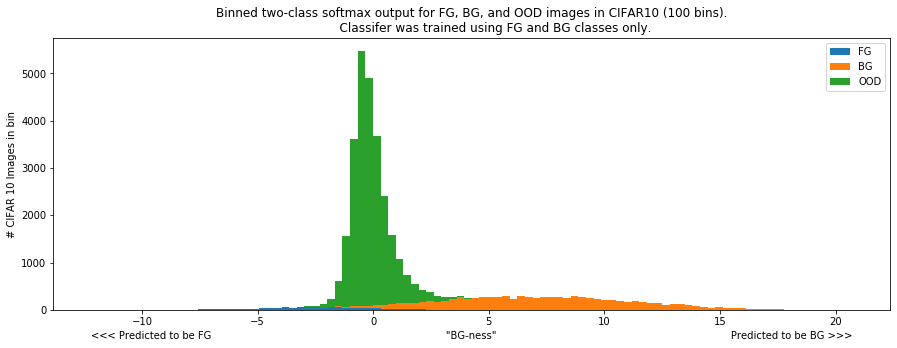

In [20]:
plt.figure(figsize=(15, 5))

fg_points = softmax_outputs[labels == 0][:,1]
bg_points = softmax_outputs[labels == 1][:,1]
ood_points = softmax_outputs[labels >= 2][:,1]

# fg_points = F.softmax(torch.Tensor(softmax_outputs[labels == 0])).numpy()[:,1]
# bg_points = F.softmax(torch.Tensor(softmax_outputs[labels == 1])).numpy()[:,1]
# ood_points = F.softmax(torch.Tensor(softmax_outputs[labels >= 2])).numpy()[:,1]

plt.hist((fg_points, bg_points, ood_points), bins=100, stacked=True, log=False, label=["FG", "BG", "OOD"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images in bin')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.legend()
plt.show()

## Penultimate feature space

### UMAP Visualization

In [ ]:
print(OOD_SET_NAME)

In [21]:
# from MulticoreTSNE import MulticoreTSNE as TSNE

# embedding = TSNE(n_jobs=4).fit_transform(conv_feats.reshape(conv_feats.shape[0], -1))

with h5py.File(RESULTS_FILE, 'r') as f: 
    mahalanobis_feats_val = f['val/mahalanobis_features'].value
    mahalanobis_feats_ood = f[f'{OOD_SET_NAME}/mahalanobis_features'].value    
    mahalanobis_features = np.concatenate([mahalanobis_feats_val, mahalanobis_feats_ood], axis=0)
    
    labels_val = f['val/labels'].value
    labels_ood = f[f'{OOD_SET_NAME}/labels'].value    
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    labels[labels > NUM_CLASSES] = NUM_CLASSES    

embedding = umap.UMAP().fit_transform(mahalanobis_features)

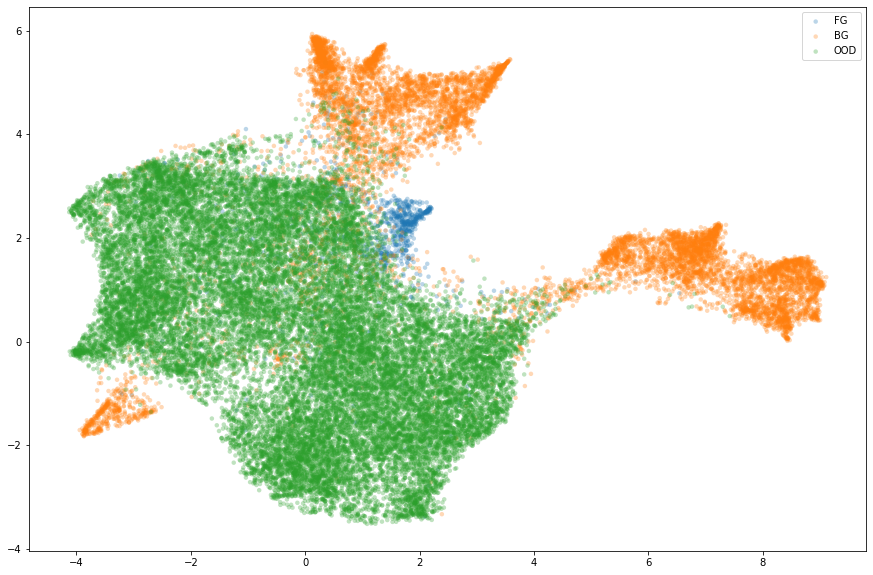

In [22]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(15, 10))
text_labels = ['FG', 'BG', 'OOD']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

In [23]:
# from MulticoreTSNE import MulticoreTSNE as TSNE

# embedding = TSNE(n_jobs=4).fit_transform(conv_feats.reshape(conv_feats.shape[0], -1))

OOD_SET_NAME = 'ood'

with h5py.File(RESULTS_FILE, 'r') as f: 
    mahalanobis_feats_val = f['val/mahalanobis_features'].value
    mahalanobis_feats_ood = f[f'{OOD_SET_NAME}/mahalanobis_features'].value    
    mahalanobis_features = np.concatenate([mahalanobis_feats_val, mahalanobis_feats_ood], axis=0)
    
    labels_val = f['val/labels'].value
    labels_ood = f[f'{OOD_SET_NAME}/labels'].value    
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    labels[labels > NUM_CLASSES] = NUM_CLASSES    

embedding = umap.UMAP().fit_transform(mahalanobis_features)

/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


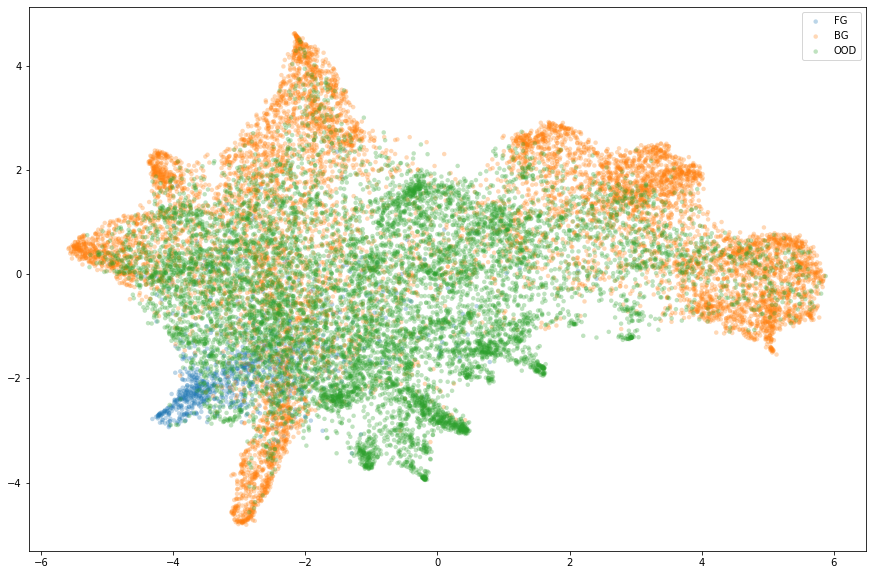

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
text_labels = ['FG', 'BG', 'OOD']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

In [26]:
# from MulticoreTSNE import MulticoreTSNE as TSNE

# embedding = TSNE(n_jobs=4).fit_transform(conv_feats.reshape(conv_feats.shape[0], -1))

with h5py.File(RESULTS_FILE, 'r') as f:
    svm_feats_val = f['val/svm/layer_16'].value
    svm_feats_ood = f[f'{OOD_SET_NAME}/svm/layer_16'].value    
    svm_features = np.concatenate([svm_feats_val, svm_feats_ood], axis=0)
    
    labels_val = f['val/labels'].value
    labels_ood = f[f'{OOD_SET_NAME}/labels'].value    
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    labels[labels > NUM_CLASSES] = NUM_CLASSES    

embedding = umap.UMAP().fit_transform(svm_features)

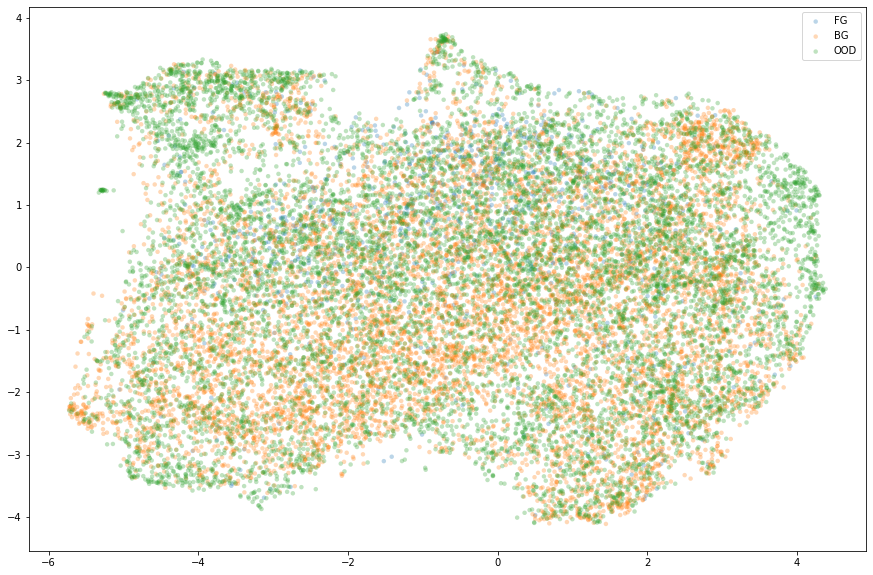

In [27]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(15, 10))
text_labels = ['FG', 'BG', 'OOD']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

In [28]:
# from MulticoreTSNE import MulticoreTSNE as TSNE

# embedding = TSNE(n_jobs=4).fit_transform(conv_feats.reshape(conv_feats.shape[0], -1))

OOD_SET_NAME = 'svhn'

with h5py.File(RESULTS_FILE, 'r') as f:
    svm_feats_val = f['val/svm/layer_16'].value
    svm_feats_ood = f[f'{OOD_SET_NAME}/svm/layer_16'].value    
    svm_features = np.concatenate([svm_feats_val, svm_feats_ood], axis=0)
    
    labels_val = f['val/labels'].value
    labels_ood = f[f'{OOD_SET_NAME}/labels'].value    
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    labels[labels > NUM_CLASSES] = NUM_CLASSES    

embedding = umap.UMAP().fit_transform(svm_features)

/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


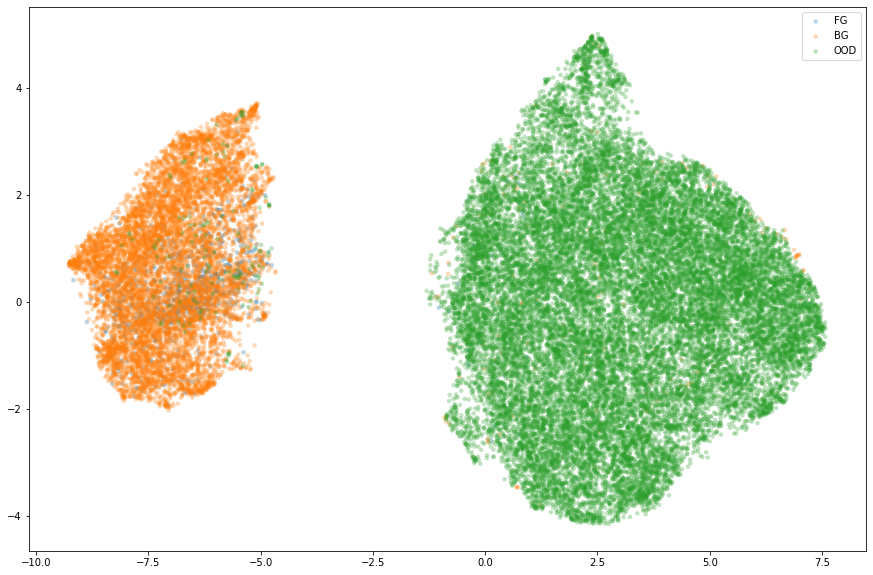

In [29]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(15, 10))
text_labels = ['FG', 'BG', 'OOD']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

# next steps

- Better MC-Dropout implementation with more dropout layers
- Look at zero-shot learning as method for determining new classes for OOD images
- Read fishy-scapes paper
- Consider using soft-sampling for robust object detection technique for training object detector
- Implement One class NN model for detecting objects instead of hard negative mining (https://arxiv.org/pdf/1801.05365.pdf)